In [280]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
%config InlineBackend.figure_formats = ['svg']


In [ ]:
blue = '#3C608A'
lightgray = '#d3d8d6'
darkblue = '#2e4465'
bpc_darkgray = '#333638'
red = '#e43e47'
lightblue = '#3687e7'
mustard = '#D4AD50'
purple = '#5E233B'
pink = '#F87FAB'

In [281]:
df = pd.read_csv('data/cleaned_verifier_data.csv', converters={'FIPS code': str}).convert_dtypes()

# Non-VVSG equipment
non_voting_equipment = ['Paper Poll Book',
                        'Hand Counted Paper Ballots', 
                        'Commercial Electronic Poll Book',
                        'In-House Electronic Poll Book',
                        'Data Unavailable',
                        'Internet Voting: Email',
                        'Internet Voting: Web Portal',
                        'Internet Voting: Fax',
                        'Remote Ballot Marking System: Client-Side',
                        'Remote Ballot Marking System: Server-Side']

# VVSG equipment
voting_equipment = ['Ballot Marking Device', 
                            'Hand-Fed Optical Scanner',
                            'Batch-Fed Optical Scanner',
                            'DRE-Touchscreen',
                            'DRE-Push Button',
                            'DRE-Dial',
                            'Mechanical Lever Machine',
                            'Punch Card Voting System',
                            'Hybrid BMD/Tabulator',
                            'Hybrid Optical Scan/DRE',
                            'Hybrid Optical Scan/BMD']

# filter only for VVSG relevant equipment
df = df[df['Equipment Type'].isin(voting_equipment)]

# merge DRE categories
df.loc[df['Equipment Type'].str.startswith('DRE'), 'Equipment Type'] = 'DRE'


/var/folders/4t/gs7xjwb92bd6lfy7w82b3s4r0000gn/T/ipykernel_52250/2523839001.py:1: DtypeWarning: Columns (19) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('data/cleaned_verifier_data.csv', converters={'FIPS code': str}).convert_dtypes()


# Histogram of equipment age

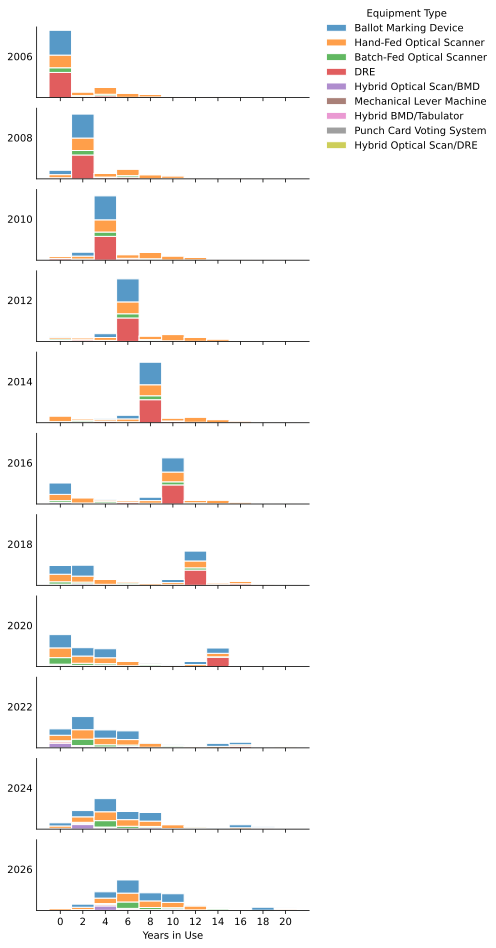

In [282]:
bins=np.arange(0,23,2)
midpoints = (bins[:-1] + bins[1:]) // 2
g = sns.displot(data=df, row='Year', x='Years in Use', kind='hist', height=1.2, aspect=4, bins=bins, hue='Equipment Type', multiple='stack', edgecolor='white')
g.legend.set_loc('upper right')

axes = g.axes
axes[0][0].set_yticks([])
axes[0][0].set_xticks(midpoints)
axes[0][0].set_xticklabels(bins[:-1])

for ax in axes:
    ax = ax[0]
    ax.set_ylabel(ax.title.get_text()[-4:], rotation=0, ha='right')
    ax.set_title('')  # Remove the title

plt.subplots_adjust(hspace=0.15)


# Histogram of equipment age (smooth)

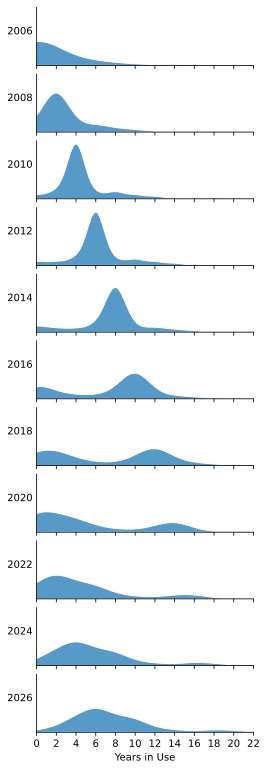

In [283]:
bins=np.arange(0,23,2)
midpoints = (bins[:-1] + bins[1:]) // 2
g = sns.displot(data=df, row='Year', x='Years in Use', kind='kde', bw_adjust=2, height=1, aspect=4, multiple='stack', edgecolor='white')

axes = g.axes
axes[0][0].set_yticks([])
axes[0][0].set_xticks(bins)
# axes[0][0].set_xticklabels(bins[:-1])
axes[0][0].set_xlim([bins[0], bins[-1]])

for ax in axes:
    ax = ax[0]
    ax.set_ylabel(ax.title.get_text()[-4:], rotation=0, ha='right')
    ax.set_title('')  # Remove the title

plt.subplots_adjust(hspace=0.15)


# Average age of equipment in 2026

In [284]:
voting_df_26 = df[df["Year"]==2026]
state_eq_len = pd.DataFrame(voting_df_26.groupby(["State"])["Years in Use"].mean())
state_eq_len.sort_values(["Years in Use"], ascending=False).round(1)

,Years in Use
State,
Oklahoma,14.0
Puerto Rico,14.0
Louisiana,13.8
Massachusetts,13.5
Indiana,13.0
Tennessee,10.6
Maine,10.3
Maryland,10.0
Northern Mariana Islands,10.0


# Age of equipment over time

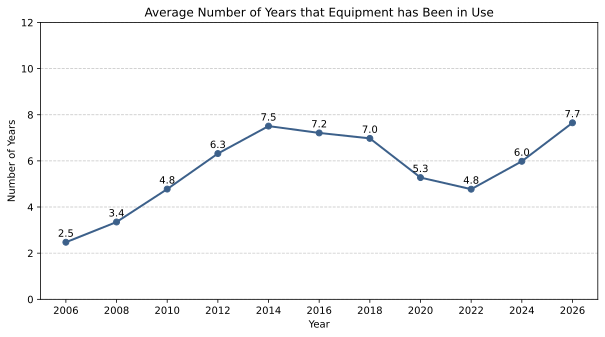

In [285]:
years_in_use = df.groupby(["Year"])["Years in Use"].mean().reset_index()

# Plot
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(years_in_use["Year"], years_in_use["Years in Use"], marker="o", linestyle="-", color=blue, linewidth=2)

# Add data labels
for i, value in enumerate(years_in_use["Years in Use"]):
    ax.text(years_in_use["Year"][i], value+.15, f"{value:.1f}", ha="center", va="bottom", fontsize=10, color="black")

# Formatting
ax.set_ylabel("Number of Years", fontsize=10)
ax.set_xlabel("Year", fontsize=10)
ax.set_title("Average Number of Years that Equipment has Been in Use", fontsize=12)
ax.grid(axis="y", linestyle="--", alpha=0.7)

# Ensure x-axis ticks are formatted correctly
plt.xticks(years_in_use["Year"], rotation=0, ha="center")

plt.ylim(0, 12)
plt.savefig("figs/avg_years_in_use.png")
plt.show()

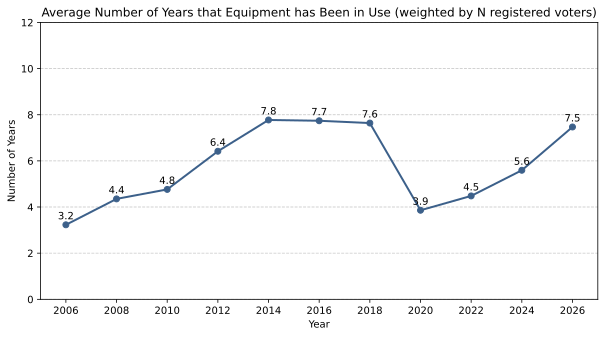

In [286]:
# Compute weighted average years in use per year
filtered_voting_df = df.dropna(subset=["Years in Use", "Registered Voters"])

years_in_use = (
    filtered_voting_df.groupby("Year")
    .apply(lambda x: np.average(x["Years in Use"], weights=x["Registered Voters"]), include_groups=False)
    .reset_index(name="Weighted Years in Use")
)

# Plot
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(years_in_use["Year"], years_in_use["Weighted Years in Use"], marker="o", linestyle="-", color=blue, linewidth=2)

# Add data labels
for i, value in enumerate(years_in_use["Weighted Years in Use"]):
    ax.text(years_in_use["Year"][i], value + 0.15, f"{value:.1f}", ha="center", va="bottom", fontsize=10, color="black")

# Formatting
ax.set_ylabel("Number of Years", fontsize=10)
ax.set_xlabel("Year", fontsize=10)
ax.set_title("Average Number of Years that Equipment has Been in Use (weighted by N registered voters)", fontsize=12)
ax.grid(axis="y", linestyle="--", alpha=0.7)

# Ensure x-axis ticks are formatted correctly
plt.xticks(years_in_use["Year"], rotation=0, ha="center")

plt.ylim(0, 12)
plt.savefig("figs/weighted_avg_years_in_use.png")
plt.show()


# Compare age of current equipment to typical age at retirement (weighted by N registered voters)

In [287]:
# sanity check on N voters before using it to calculate weighted average
n = df[df['Year']==2026].drop_duplicates(subset='FIPS code', keep='first')['Registered Voters'].sum()
f"{n:,} registered voters across jurisdictions with voting equipment in 2026"

# https://www.eac.gov/sites/default/files/2024-11/2022_EAVS_Report_508c.pdf#page=6
# "More than 203 million individuals were
# active registered voters for the 2022 general election,"
# this is close enough, i think! sanity check passed

'221,877,727 registered voters across jurisdictions with voting equipment in 2026'

In [288]:
# Function to calculate weighted average and weighted std
def weighted_stats(group):
    weights = group["Registered Voters"]
    values = group["Years in Use"]
    
    # Weighted average
    avg = np.average(values, weights=weights)
    
    # Weighted standard deviation
    variance = np.average((values - avg)**2, weights=weights)
    std_dev = np.sqrt(variance)

    N = len(group)
    
    return pd.Series({
        "Weighted Avg Age": avg,
        "Weighted Std Age": std_dev,
        "N": N
    })

filtered_df = df.dropna(subset=['Registered Voters', 'Years in Use', 'Equipment Type'])
# Apply function by Equipment Type
age_at_retirement = filtered_df[filtered_df['Final Year in Use']==True].groupby("Equipment Type").apply(weighted_stats, include_groups=False).reset_index()

# View result
age_at_retirement

current_age = filtered_df[filtered_df['Year'] == 2026].groupby("Equipment Type").apply(weighted_stats, include_groups=False).reset_index()

retirement_df = pd.merge(current_age, age_at_retirement, on='Equipment Type', how='left', suffixes=(' Current', ' At Retirement'))
retirement_df = retirement_df.loc[[3, 1, 0, 2, 5, 4]].reset_index(drop=True)
retirement_df.round(1)

,Equipment Type,Weighted Avg Age Current,Weighted Std Age Current,N Current,Weighted Avg Age At Retirement,Weighted Std Age At Retirement,N At Retirement
0,Hand-Fed Optical Scanner,7.7,4.6,4311.0,9.2,5.4,5940.0
1,Batch-Fed Optical Scanner,6.9,2.7,1509.0,8.6,4.9,1274.0
2,Ballot Marking Device,7.4,4.0,4997.0,7.6,5.6,3513.0
3,DRE,13.3,8.1,401.0,9.1,5.9,4508.0
4,Hybrid Optical Scan/BMD,8.0,2.7,938.0,2.2,1.4,24.0
5,Hybrid BMD/Tabulator,4.7,1.7,34.0,0.8,1.0,4.0


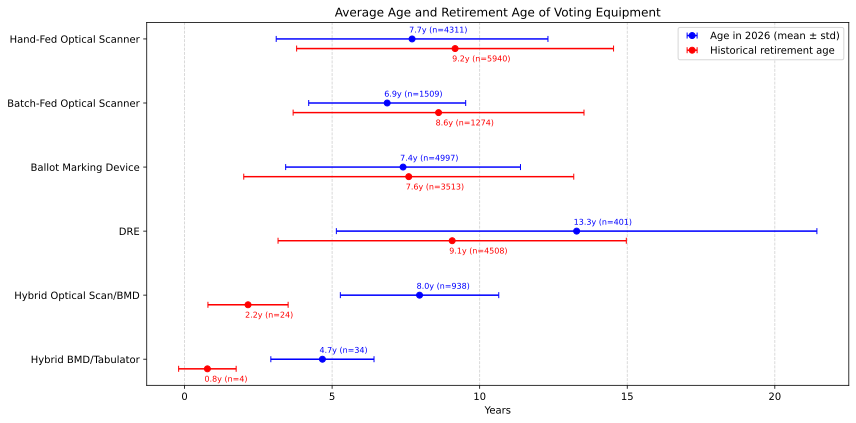

In [289]:
fig, ax = plt.subplots(figsize=(12, 6))
y = np.arange(len(retirement_df))

# Plot current age
ax.errorbar(retirement_df['Weighted Avg Age Current'], y, xerr=retirement_df['Weighted Std Age Current'],
            fmt='o', color='blue', label='Age in 2026 (mean ± std)', capsize=3)

# Annotate current age
for i, row in retirement_df.iterrows():
    label = f"{row['Weighted Avg Age Current']:.1f}y (n={int(row['N Current'])})"
    ax.text(row['Weighted Avg Age Current'] - 0.1, y[i] - 0.1, label, color='blue', fontsize=8)

# Plot retirement age
for i, row in retirement_df.iterrows():
    if pd.notnull(row['Weighted Avg Age At Retirement']):
        label = 'Historical retirement age' if i == 0 else ''
        ax.errorbar(row['Weighted Avg Age At Retirement'], y[i] + 0.15,
                    xerr=row['Weighted Std Age At Retirement'], fmt='o', label=label,
                    color='red', capsize=3)

# Annotate retirement age
for i, row in retirement_df.iterrows():
    label = f"{row['Weighted Avg Age At Retirement']:.1f}y (n={int(row['N At Retirement'])})"
    ax.text(row['Weighted Avg Age At Retirement'] - 0.1, y[i] + 0.35, label, color='red', fontsize=8)


# Formatting
ax.set_yticks(y)
ax.set_yticklabels(retirement_df['Equipment Type'])
ax.invert_yaxis()  # So first row is on top
ax.set_xlabel('Years')
ax.set_title('Average Age and Retirement Age of Voting Equipment')
ax.grid(True, axis='x', linestyle='--', alpha=0.6)
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()


# New equipment acquisitions

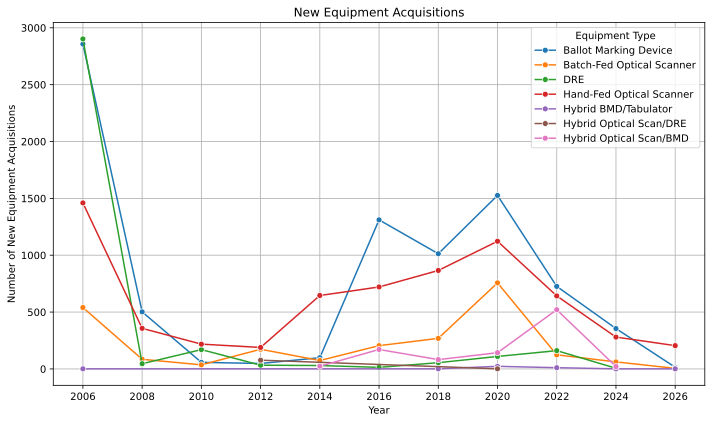

In [4]:
# Group by year and equipment type, and count
df_grouped = df[df['New Equipment']].groupby(['Year', 'Equipment Type']).size().reset_index(name='Count')

# Plot with seaborn
plt.figure(figsize=(10, 6))
sns.lineplot(data=df_grouped, x='Year', y='Count', hue='Equipment Type', marker='o')

plt.title('New Equipment Acquisitions')
plt.xlabel('Year')
plt.ylabel('Number of New Equipment Acquisitions')
plt.xticks(sorted(df['Year'].unique()))
plt.grid(True)
plt.tight_layout()
plt.show()


When new voting equipment infusions happen

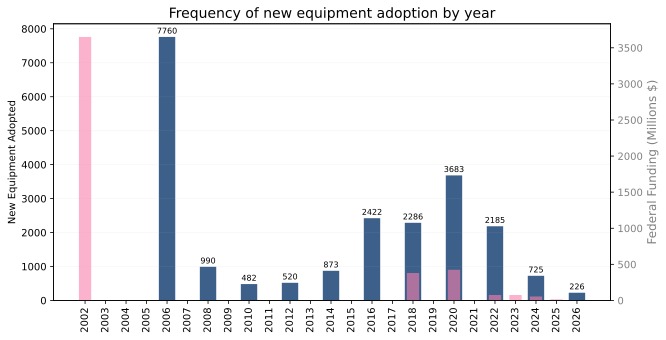

In [276]:
year_enacted = [2002, 2018, 2020, 2020, 2022, 2023, 2024, 2025,2026]
federal_funding_millions = [3650, 380, 400, 425, 75, 75, 55, 15,0]

# Compute new equipment counts per year
new_equipment_counts = df.groupby("Year")["New Equipment"].sum()

# Convert index to integers for consistent plotting
new_equipment_counts.index = new_equipment_counts.index.astype(int)

# Ensure all years are included in the x-axis range
all_years = np.arange(min(year_enacted), max(year_enacted) + 1)

# Align federal funding with years
funding_dict = dict(zip(year_enacted, federal_funding_millions))
funding_values = [funding_dict.get(year, 0) for year in all_years]  # Fill missing years with 0

# Create figure and axes
fig, ax1 = plt.subplots(figsize=(10, 5))

ax1.grid(axis="y", linestyle="-", alpha=0.1)

# Primary y-axis (New Equipment Adoption)
ax1.bar(new_equipment_counts.index, new_equipment_counts, color=blue)
ax1.set_ylabel("New Equipment Adopted")

# Add data labels
for year, value in new_equipment_counts.items():
    ax1.text(year, value + 100, str(value), ha="center", fontsize=8)

# Secondary y-axis (Federal Funding)
ax2 = ax1.twinx()
ax2.bar(all_years, funding_values, color=pink, alpha=0.6, label="Federal Funding ($M)", width=0.6)
ax2.set_ylabel("Federal Funding (Millions $)", fontsize=12, color="gray")
ax2.tick_params(axis="y", labelcolor="gray")

# Set x-axis to show all years
ax1.set_xticks(all_years)
ax1.set_xticklabels(all_years, rotation=90)

# Titles & Legends
ax1.set_title("Frequency of new equipment adoption by year", fontsize=14)
plt.savefig("figs/new_eq_freq_gap.png")
plt.show()